In [1]:
import torch
import torch.nn.functional as F
import requests
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
# from datasets import load_dataset

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import logging
logger = logging.getLogger(__name__)

func_to_enable_grad = '_sample'
setattr(LlavaForConditionalGeneration, func_to_enable_grad, torch.enable_grad(getattr(LlavaForConditionalGeneration, func_to_enable_grad)))

C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "llava-hf/llava-1.5-7b-hf"
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    offload_state_dict=True
)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    quantization_config=quant_config,
    attn_implementation = "eager"
).to(0)

#--------------------------------------------------
model.vision_tower.config.output_attentions = True

# set hooks to get attention weights
model.enc_attn_weights = []
#outputs: attn_output, attn_weights, past_key_value
def forward_hook(module, inputs, output): 
    if output[1] is None:
        logger.error(
            ("Attention weights were not returned for the encoder. "
            "To enable, set output_attentions=True in the forward pass of the model. ")
        )
        return output
    
    output[1].requires_grad_(True)
    output[1].retain_grad()
    model.enc_attn_weights.append(output[1].detach().cpu())
    return output

hooks_pre_encoder, hooks_encoder = [], []
for layer in model.language_model.layers:
    hook_encoder_layer = layer.self_attn.register_forward_hook(forward_hook)
    hooks_pre_encoder.append(hook_encoder_layer)

model.enc_attn_weights_vit = []

def forward_hook_image_processor(module, inputs, output): 
    if output[1] is None:
        logger.warning(
            ("Attention weights were not returned for the vision model. "
             "Relevancy maps will not be calculated for the vision model. " 
             "To enable, set output_attentions=True in the forward pass of vision_tower. ")
        )
        return output

    output[1].requires_grad_(True)
    output[1].retain_grad()
    model.enc_attn_weights_vit.append(output[1])
    return output

hooks_pre_encoder_vit = []
for layer in model.vision_tower.vision_model.encoder.layers:
    hook_encoder_layer_vit = layer.self_attn.register_forward_hook(forward_hook_image_processor)
    hooks_pre_encoder_vit.append(hook_encoder_layer_vit)
#--------------------------------------------------

processor = AutoProcessor.from_pretrained(model_id)

if model.language_model.config.model_type == "gemma":
    eos_token_id = processor.tokenizer('<end_of_turn>', add_special_tokens=False).input_ids[0]
else:
    eos_token_id = processor.tokenizer.eos_token_id

`torch_dtype` is deprecated! Use `dtype` instead!
C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\transformers\modeling_utils.py:6231: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  _ = torch.empty(byte_count // factor, dtype=torch.float16, device=device, requires_grad=False)
Fetching 2 files: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
tokens = torch.load("full_generation.pt").tolist()
# Decode each token individually
decoded_tokens = [processor.decode([t]) for t in tokens]

# Optionally, print
for i, tok in enumerate(decoded_tokens):
    print(f"{i}: {repr(tok)}")

In [ ]:
file = r"saved/vit_attn"
import os
torch.save(tokens, os.path.join(file, "lmao.pt"))

In [3]:
conversation = [
    {
      "role": "user",
      "content": [
          {"type": "text", "text": "What is the vehicle in this image?"},
          {"type": "image"},
        ],
    },
]
conv_step = conversation + [
    {"role": "assistant", "content": [{"type": "text", "text": "The vehicle in this image is a large"}]}
]
conv_step

[{'role': 'user',
  'content': [{'type': 'text', 'text': 'What is the vehicle in this image?'},
   {'type': 'image'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'The vehicle in this image is a large'}]}]

In [4]:
image_file = r"D:\aircraft_images\02\data\11GMrpjJl48P1peK0.jpg"
raw_image = Image.open(image_file).convert("RGB")
prompt_appended = processor.apply_chat_template(conv_step, add_generation_prompt=False, return_tensors="pt")
inputs_appended = processor(images=raw_image, text=prompt_appended, return_tensors='pt').to(0, torch.float16)

output_appended = model(**inputs_appended,
                        use_cache=False,
                        output_attentions=True,
                        output_hidden_states=True,
                        return_dict_in_generate=True,
                        output_scores=True,
                        eos_token_id=eos_token_id)
print(len(model.enc_attn_weights))

32


In [5]:
decoded_input_tokens = [processor.decode([t]) for t in inputs_appended["input_ids"][0]]

# Optionally, print
for i, tok in enumerate(decoded_input_tokens):
    print(f"{i}: {repr(tok)}")

0: '<s>'
1: 'US'
2: 'ER'
3: ':'
4: ''
5: '<image>'
6: '<image>'
7: '<image>'
8: '<image>'
9: '<image>'
10: '<image>'
11: '<image>'
12: '<image>'
13: '<image>'
14: '<image>'
15: '<image>'
16: '<image>'
17: '<image>'
18: '<image>'
19: '<image>'
20: '<image>'
21: '<image>'
22: '<image>'
23: '<image>'
24: '<image>'
25: '<image>'
26: '<image>'
27: '<image>'
28: '<image>'
29: '<image>'
30: '<image>'
31: '<image>'
32: '<image>'
33: '<image>'
34: '<image>'
35: '<image>'
36: '<image>'
37: '<image>'
38: '<image>'
39: '<image>'
40: '<image>'
41: '<image>'
42: '<image>'
43: '<image>'
44: '<image>'
45: '<image>'
46: '<image>'
47: '<image>'
48: '<image>'
49: '<image>'
50: '<image>'
51: '<image>'
52: '<image>'
53: '<image>'
54: '<image>'
55: '<image>'
56: '<image>'
57: '<image>'
58: '<image>'
59: '<image>'
60: '<image>'
61: '<image>'
62: '<image>'
63: '<image>'
64: '<image>'
65: '<image>'
66: '<image>'
67: '<image>'
68: '<image>'
69: '<image>'
70: '<image>'
71: '<image>'
72: '<image>'
73: '<image>'
7

In [83]:
print(output_appended.logits.shape)
# Decode them
topk = torch.topk(output_appended.logits[:, -2], k=1, dim=-1)
for ids in topk.indices:
    print(processor.tokenizer.decode(ids))

torch.Size([1, 605, 32064])
jet


In [91]:
hidden_state = output_appended.hidden_states[11]
logits_from_hidden_state = model.lm_head(hidden_state)

# Decode them
topk = torch.topk(logits_from_hidden_state[:, -2], k=1, dim=-1)
for ids in topk.indices:
    print(processor.tokenizer.decode(ids))

幸


In [7]:
def attention_rollout(attn_maps):
    """
    Performs rollout on the provided attention maps. Pass in the model attn weights e.g. model.enc_attn_weights[0:32]
    """
    attn_rollout = []
    device = attn_maps[0].device
    batch_size, _, seq_len, _ = attn_maps[0].shape
    
    # Identity matrix for self-attention
    I = torch.eye(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len, seq_len)

    prod = I.clone()
    
    for i, attn_map in enumerate(attn_maps):
        # Average over heads → [batch, seq_len, seq_len]
        attn_map = attn_map.mean(dim=1)
        
        # Add identity and multiply
        prod = prod @ (attn_map + I)
        
        # Normalize across sequence dimension
        prod = prod / prod.sum(dim=-1, keepdim=True)
        
        attn_rollout.append(prod)

    return attn_rollout

In [8]:
rollout = attention_rollout(model.enc_attn_weights[0:32])
final_rollout = rollout[-1]
print(final_rollout.shape)

torch.Size([1, 605, 605])


In [9]:
seq_len = final_rollout.shape[1]
valid_range = range(1, seq_len)  # skip token 0
token_importances = final_rollout[0, -2, valid_range]  # importance of all tokens for position t
topk = 400
values, indices = torch.topk(token_importances, k=topk)
for score, idx in zip(values.tolist(), indices.tolist()):
    if idx >= 5 and idx <= 580:
        continue
    print(f"Token {idx} → importance {score}")


Token 0 → importance 6.079209580178713e-09
Token 4 → importance 5.176531647776983e-09
Token 585 → importance 2.489382922021832e-09
Token 581 → importance 2.3914363822541418e-09
Token 2 → importance 2.32942154454463e-09
Token 582 → importance 1.793702741892389e-09
Token 1 → importance 1.7209436098397646e-09
Token 3 → importance 1.6161311178208848e-09
Token 588 → importance 1.006755789845215e-09
Token 591 → importance 9.202608675096258e-10
Token 583 → importance 8.968368270245719e-10
Token 584 → importance 8.159003472840709e-10
Token 587 → importance 7.532672818832964e-10
Token 589 → importance 6.965863441621423e-10
Token 586 → importance 6.89123424990612e-10
Token 594 → importance 6.852315381777885e-10
Token 593 → importance 6.214699865836337e-10
Token 596 → importance 6.184937006992186e-10
Token 590 → importance 6.137562125196894e-10
Token 592 → importance 5.647374234918345e-10
Token 602 → importance 5.611329179089353e-10
Token 601 → importance 5.050304063836109e-10
Token 595 → importa

In [15]:
last_attn = model.enc_attn_weights[-1].mean(dim=1)  # [batch, seq_len, seq_len]
length = last_attn.shape[1]
token_importances = last_attn[0, length-2]    # attention from t → all tokens
topk = 100
values, indices = torch.topk(token_importances, k=topk)
for score, idx in zip(values.tolist(), indices.tolist()):
    print(f"Token {idx} → importance {score}")

605
Token 0 → importance 0.634765625
Token 603 → importance 0.08251953125
Token 602 → importance 0.045379638671875
Token 601 → importance 0.01090240478515625
Token 222 → importance 0.00812530517578125
Token 582 → importance 0.0080413818359375
Token 594 → importance 0.0075836181640625
Token 425 → importance 0.006961822509765625
Token 223 → importance 0.006290435791015625
Token 600 → importance 0.00562286376953125
Token 593 → importance 0.0052490234375
Token 599 → importance 0.00505828857421875
Token 470 → importance 0.0049285888671875
Token 597 → importance 0.00473785400390625
Token 591 → importance 0.004573822021484375
Token 523 → importance 0.004383087158203125
Token 588 → importance 0.00411224365234375
Token 439 → importance 0.003932952880859375
Token 162 → importance 0.003696441650390625
Token 596 → importance 0.003559112548828125
Token 408 → importance 0.0034542083740234375
Token 583 → importance 0.0033435821533203125
Token 586 → importance 0.0033206939697265625
Token 595 → importa

# Generate heatmap of important image tokens from rollout

torch.Size([1, 605, 605])
0
1
586
582
3
583
2
4


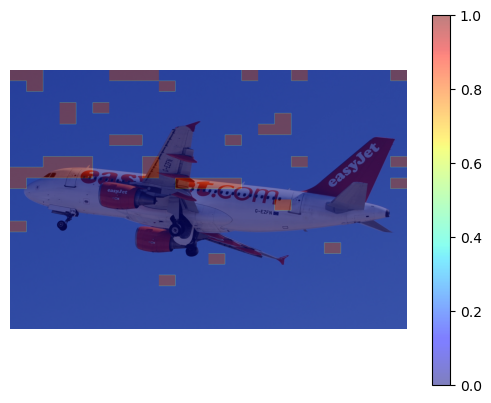

In [48]:
import numpy as np
import torch 

rollout = attention_rollout(model.enc_attn_weights[0:32])
final_rollout = rollout[-1]
print(final_rollout.shape)
token_importances = final_rollout[0, -2]  # importance of all tokens for position t
topk = 50
values, indices = torch.topk(token_importances, k=topk)
heatmap_raw = [0 for i in range(576)]
for score, idx in zip(values.tolist(), indices.tolist()):
    if idx >= 5 and idx <= 580:
        heatmap_raw[idx-5] = 1
    else:
        print(idx)

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

cls_attn = torch.tensor(heatmap_raw)
H, W = 24, 24  # 336 / 14
heatmap = cls_attn.reshape(H, W).detach().cpu().numpy()

# Assuming heatmap shape [H, W]
heatmap_tensor = torch.tensor(heatmap[None, None], dtype=torch.float32)
heatmap_full = F.interpolate(heatmap_tensor, size=(raw_image.size[1], raw_image.size[0]), mode='area')[0,0].numpy()

image = Image.open(image_file).convert("RGB")
plt.imshow(image)
plt.imshow(heatmap_full, cmap='jet', alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

# Generate heatmap of important image tokens from last attention block

0
603
604
602
582
601
594
593
591
597
588
600
1
586
596
599
581
583
592
4
590
595


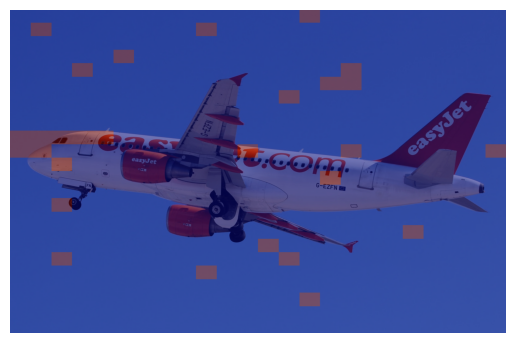

In [53]:
last_attn = model.enc_attn_weights[-1].mean(dim=1)  # [batch, seq_len, seq_len]
length = last_attn.shape[1]
token_importances = last_attn[0, length-1]    # attention from t → all tokens
topk = 50
values, indices = torch.topk(token_importances, k=topk)
heatmap_raw = [0 for i in range(576)]
for score, idx in zip(values.tolist(), indices.tolist()):
    if idx >= 5 and idx <= 580:
        heatmap_raw[idx-5] = 1
    else:
        print(idx)

cls_attn = torch.tensor(heatmap_raw)
H, W = 24, 24  # 336 / 14
heatmap = cls_attn.reshape(H, W).detach().cpu().numpy()

# Assuming heatmap shape [H, W]
heatmap_tensor = torch.tensor(heatmap[None, None], dtype=torch.float32)
heatmap_full = F.interpolate(heatmap_tensor, size=(raw_image.size[1], raw_image.size[0]), mode='nearest')[0,0].numpy()

image = Image.open(image_file).convert("RGB")
plt.imshow(image)
plt.imshow(heatmap_full, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()